# importar Librerias

In [124]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate
from IPython.display import Audio, display
import sounddevice as sd

# Parametros generales

In [125]:
FS = 48000
F_RANGE = [4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000]  # Frecuencias de los tonos (Hz)
Ts = 0.01  # Duración de símbolo en segundos


# Convertir texto a ascii binario

In [126]:
# Convertir texto a ascii binario
def text_to_bits(text):
    bits = []
    for char in text:
        bin_char = format(ord(char), '08b')
        bits.extend([int(b) for b in bin_char])
    return bits

# Convertir ascii binario a texto
def bits_to_text(bits):
    chars = []
    for b in range(0, len(bits), 8):
        byte = bits[b:b+8]
        byte_str = ''.join(str(bit) for bit in byte)
        chars.append(chr(int(byte_str, 2)))
    return ''.join(chars)

# Relacionar frecuencias con simbolos

In [127]:
# 4000hz -> 000 0
# 5000hz -> 001 1
# 6000hz -> 010 2 
# 7000hz -> 011 3 
# 8000hz -> 100 4 
# 9000hz -> 101 5 
# 10000hz -> 110 6 
# 11000hz -> 111 7
def bits_to_symbols(bits):
    symbols = []
    for i in range(0, len(bits), 3):
        symbol_bits = bits[i:i+3]
        symbol = symbol_bits[0]*4 + symbol_bits[1]*2 + symbol_bits[2]*1
        symbols.append(symbol)
    return symbols

def symbols_to_bits(symbols):
    bits = []
    for symbol in symbols:
        bits.append((symbol >> 2) & 1)
        bits.append((symbol >> 1) & 1)
        bits.append(symbol & 1)
    return bits

# Prueba
print("Prueba de conversión texto <-> bits <-> símbolos")
mensaje = "Hola"
bits = text_to_bits(mensaje)
print("Bits:", bits)
# Garantizar que la cantidad de bits es múltiplo de 3
while len(bits) % 3 != 0:
    bits.append(0)  # Padding con ceros
symbols = bits_to_symbols(bits)
print("Símbolos:", symbols)
bits_recuperados = symbols_to_bits(symbols)
mensaje_recuperado = bits_to_text(bits_recuperados)
print("Mensaje recuperado:", mensaje_recuperado)

Prueba de conversión texto <-> bits <-> símbolos
Bits: [0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1]
Símbolos: [2, 2, 0, 6, 7, 5, 5, 4, 3, 0, 2]
Mensaje recuperado: Hola 


# Crear mensaje con duracion de Ts


Prueba de creación de mensaje


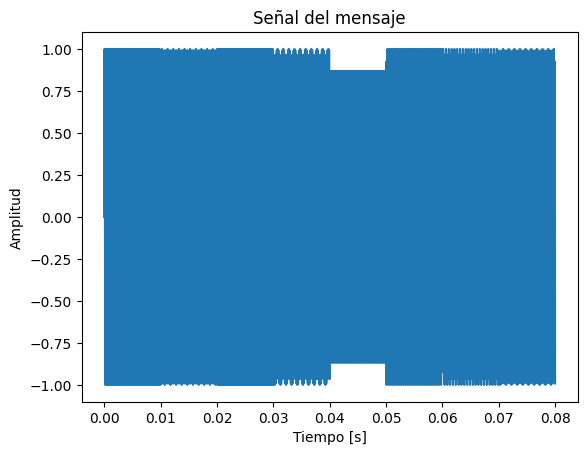


Prueba de decodificación de mensaje
Símbolos recibidos: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]
Mensaje recibido: 9w


In [128]:
# Crear mensaje con duracion de Ts
def create_message(symbols):
    # ir agregando senoidales con duracion Ts
    t_symbol = np.arange(0, Ts, 1/FS)
    message = np.array([])
    for symbol in symbols:
        f = F_RANGE[symbol]
        tone = np.sin(2 * np.pi * f * t_symbol)
        message = np.concatenate((message, tone))
    return message

# Prueba
print("\nPrueba de creación de mensaje")
symbols = [0, 1, 2, 3, 4, 5, 6, 7]
message_signal = create_message(symbols)
t_message = np.arange(len(message_signal)) / FS
plt.figure()
plt.plot(t_message, message_signal)
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.title("Señal del mensaje")
plt.show()
display(Audio(message_signal, rate=FS))

# Decodificar mensaje
def decode_message(received_signal):
    # Filtra por pasa bandas y mide energía
    symbol_duration_samples = int(Ts * FS)
    num_symbols = len(received_signal) // symbol_duration_samples
    received_symbols = []
    for i in range(num_symbols):
        segment = received_signal[i*symbol_duration_samples:(i+1)*symbol_duration_samples]
        energies = []
        for f in F_RANGE:
            t = np.arange(0, Ts, 1/FS)
            tone = np.sin(2 * np.pi * f * t)
            energy = np.sum(segment * tone)
            energies.append(energy)
        detected_symbol = np.argmax(energies)
        received_symbols.append(detected_symbol)
    return received_symbols
# Prueba
print("\nPrueba de decodificación de mensaje")
received_symbols = decode_message(message_signal)
print("Símbolos recibidos:", received_symbols)
received_bits = symbols_to_bits(received_symbols)
received_message = bits_to_text(received_bits)
print("Mensaje recibido:", received_message)

# Recibir audio por microfono


Prueba de recepción por micrófono
Grabando por micrófono...
Grabación completa.


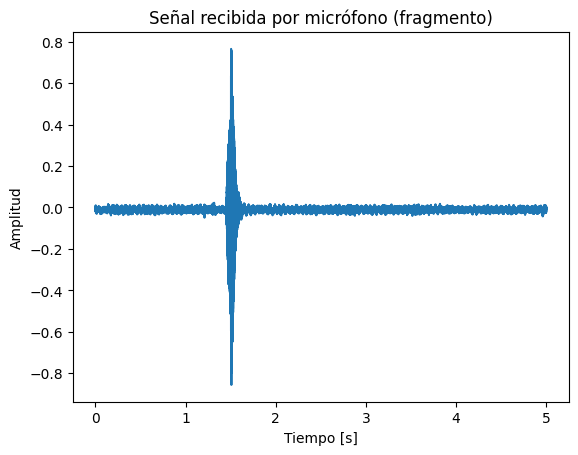

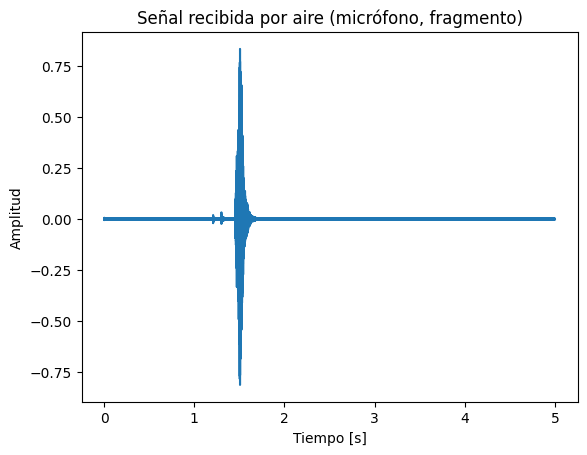

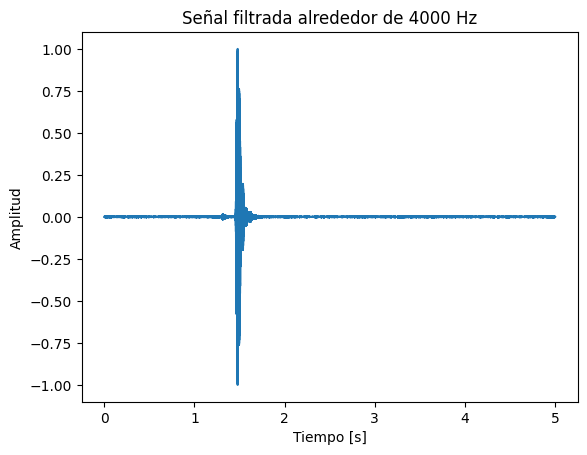

Frecuencia 4000 Hz detectada entre 1.48 s y 1.48 s


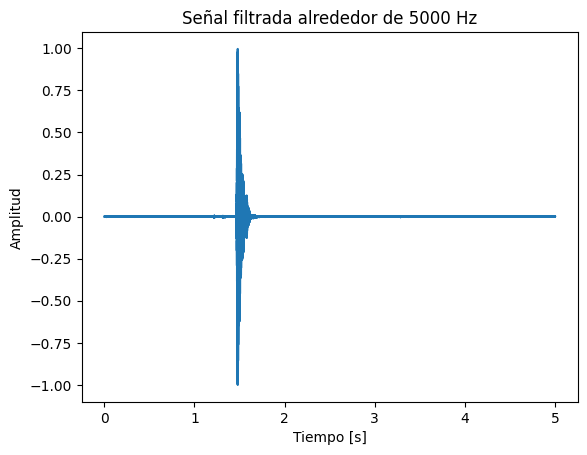

Frecuencia 5000 Hz detectada entre 1.48 s y 1.48 s


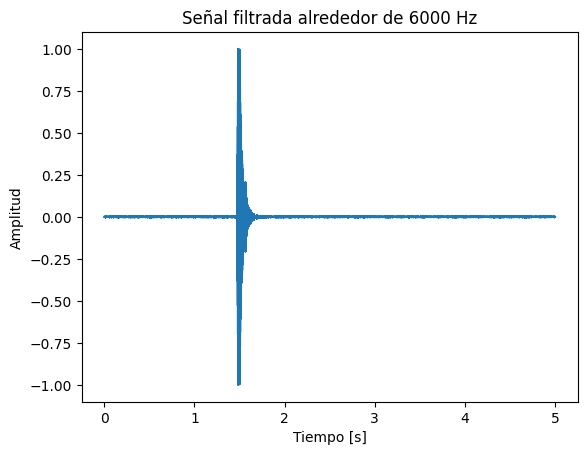

Frecuencia 6000 Hz detectada entre 1.49 s y 1.50 s


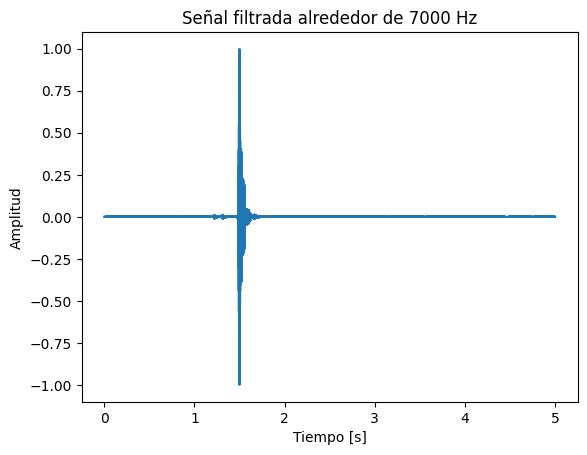

Frecuencia 7000 Hz detectada entre 1.50 s y 1.50 s


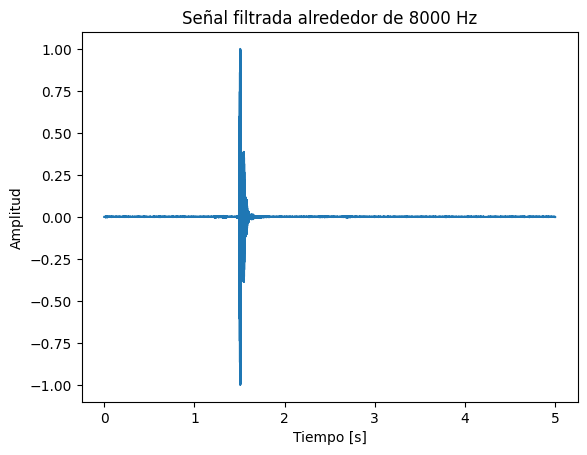

Frecuencia 8000 Hz detectada entre 1.51 s y 1.51 s


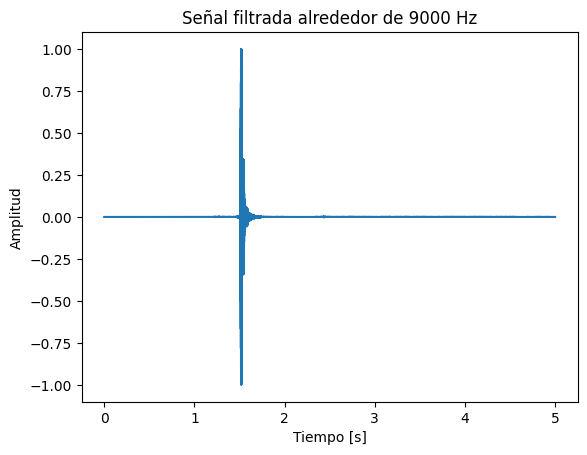

Frecuencia 9000 Hz detectada entre 1.52 s y 1.52 s


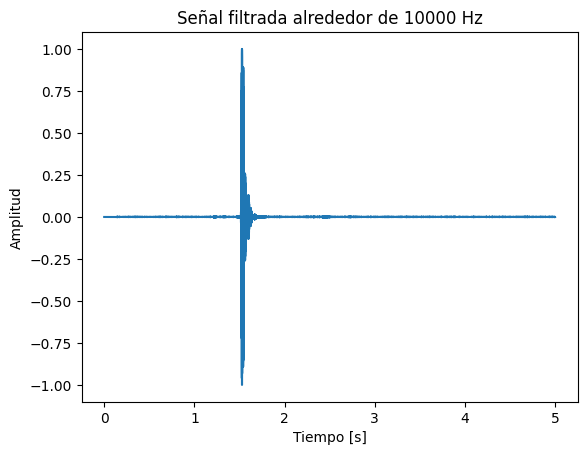

Frecuencia 10000 Hz detectada entre 1.53 s y 1.53 s


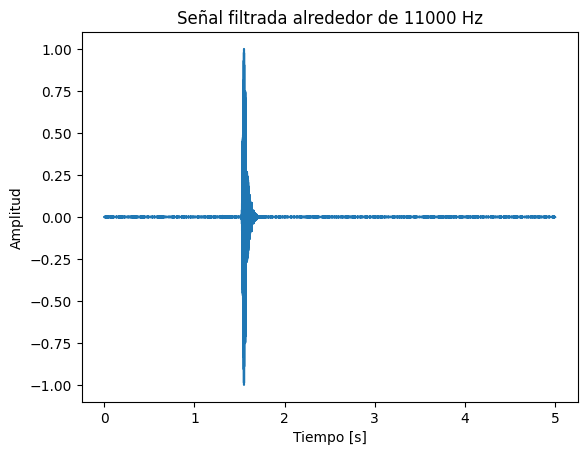

Frecuencia 11000 Hz detectada entre 1.55 s y 1.55 s


In [ ]:
# Recibir por micrófono
def receive_via_mic(duration):
    print("Grabando por micrófono...")
    recording = sd.rec(int(duration * FS), samplerate=FS, channels=1, dtype='float32')
    sd.wait()  # Esperar hasta que termine la grabación
    print("Grabación completa.")
    return recording.flatten()  # Convertir a array 1D
# Prueba
print("\nPrueba de recepción por micrófono")
duration = 5  # Duración en segundos
received_signal = receive_via_mic(duration)
# graficar fragmento de la señal recibida
t_received = np.arange(len(received_signal)) / FS
plt.figure()
plt.plot(t_received, received_signal)
plt.xlabel("Tiempo [s]")

plt.ylabel("Amplitud")
plt.title("Señal recibida por micrófono (fragmento)")
plt.show()

# Filtrar 
def bandpass_filter(signal, f_low, f_high, fs):
    from scipy.signal import butter, lfilter
    nyq = 0.5 * fs
    low = f_low / nyq
    high = f_high / nyq
    b, a = butter(5, [low, high], btype='band')
    filtered_signal = lfilter(b, a, signal)
    return filtered_signal

# Filtrar señal recibida
f_low = min(F_RANGE) - 1000
f_high = max(F_RANGE) + 1000
rx_mic = bandpass_filter(received_signal, f_low, f_high, FS)

# Graficar fragmento de la señal filtrada
t_rx_mic = np.arange(len(rx_mic)) / FS

plt.figure()
plt.plot(t_rx_mic, rx_mic)
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.title("Señal recibida por aire (micrófono, fragmento)")
plt.show()

# FIltrar señal recibida por pasa bandas cada intervalos de frecuencia
for f in F_RANGE:
    f_low = f - 50
    f_high = f + 50
    filtered = bandpass_filter(rx_mic, f_low, f_high, FS)
    t_filtered = np.arange(len(filtered)) / FS
    # normalizar
    filtered /= np.max(np.abs(filtered)) + 1e-6
    plt.figure()
    plt.plot(t_filtered, filtered)
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud")
    plt.title(f"Señal filtrada alrededor de {f} Hz")
    plt.show()
    # detectar rangos en que la amplitud es mayor a 0.7
    threshold = 0.9
    above_threshold = np.where(np.abs(filtered) > threshold)[0]
    if len(above_threshold) > 0:
        start = above_threshold[0] / FS
        end = above_threshold[-1] / FS
        print(f"Frecuencia {f} Hz detectada entre {start:.2f} s y {end:.2f} s")
    else:
        print(f"Frecuencia {f} Hz no detectada")

    # agregar 

